# GLIF 발표용 CAPM 적용 코드

http://blog.naver.com/PostView.nhn?blogId=the_bhm&logNo=220707781934 를 참고하여 작성하였음. 

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [194]:
# 삼성전자 주가, 국고채 3년물, KOSPI 데이터 로드

samsung = pd.read_pickle('./mydata/SamsungElectronics.pkl')
samsung.date = pd.to_datetime(samsung.date)
samsung.rename({'삼성전자':'samsung_close'}, axis=1, inplace=True)
samsung.samsung_close = pd.to_numeric(samsung.samsung_close)

macro_kor = pd.read_pickle('./data_provided/macro_kor.pkl')
macro_kor.date = pd.to_datetime(macro_kor.date)
BOK_3y = macro_kor[['date', 'KOR_bond_3y']]

KOSPI = pd.read_pickle('./data_provided/KOSPI_stats.pkl') #월별
KOSPI.date = pd.to_datetime(KOSPI.date)
KOSPI = KOSPI[['date', 'close']]
KOSPI.head()

xls = pd.ExcelFile('./mydata/KRX_KOSPI_series_20140228-20190228.xls')
KOSPI_daily = pd.read_excel(xls, 'Sheet1')
KOSPI_daily = KOSPI_daily[['일자', '현재지수']]
KOSPI_daily.rename({'일자':'date', '현재지수':'close'}, axis=1, inplace=True)
KOSPI_daily.date = pd.to_datetime(KOSPI_daily.date)
KOSPI_daily.close = pd.to_numeric(KOSPI_daily.close.str.replace(',', ''), errors='coerce')
# KOSPI_daily.close = KOSPI_daily.close.astype(float) # to_numeric은 decimal comma (eg: 1,900.33) 처리를 못한다. 
KOSPI_daily.head()

,date,close
0,2014-02-28,1979.99
1,2014-03-03,1964.69
2,2014-03-04,1954.11
3,2014-03-05,1971.24
4,2014-03-06,1975.62


In [195]:
# 국고채 3년물 연수익률로 Rf (Risk-free rate) 계산
# 최근 5년의 기하평균.

start_date = '03-01-2014'
end_date = '02-28-2019'

BOK_3y = BOK_3y[BOK_3y.date >= start_date]
BOK_3y.drop(BOK_3y.tail(1).index, inplace=True)

Rf = stats.gmean(BOK_3y.KOR_bond_3y, axis=0)
Rf # % (연수익률) 

1.85603392877489

In [196]:
BOK_3y.tail()

,date,KOR_bond_3y
154,2018-11-01,1.895
155,2018-12-01,1.823
156,2019-01-01,1.810
157,2019-02-01,1.812
158,2019-03-01,1.690


In [197]:
# 코스피로 Rm (Rate of market return) 계산
# 최근 5년의 기하평균

KOSPI['rateofchange'] = KOSPI.close.pct_change() # Some rate of returns are negative. We need a workaround by adding 1 and subtracting after. 
KOSPI = KOSPI[(KOSPI.date >= start_date) & (KOSPI.date <= end_date)] 
KOSPI.rateofchange = KOSPI.rateofchange + 1

Rm = stats.gmean(KOSPI.rateofchange, axis=0) # 월수익률
Rm = (Rm**12 - 1)*100 # 변환
Rm # % (연수익률)

2.087299384974095

In [198]:
# 삼성전자의 Beta 추정
# 최근 1년의 데이터를 사용

year_start_date = '05-25-2018'
year_end_date = '05-24-2019'

KOSPI_daily['KOSPI_rateofchange'] = KOSPI_daily.close.pct_change() # 코스피 daily return
KOSPI_daily = KOSPI_daily[(KOSPI_daily.date >= year_start_date) & (KOSPI_daily.date <= year_end_date)]

samsung['samsung_rateofchange'] = samsung.samsung_close.pct_change() # 삼성전자 daily return
samsung = samsung[(samsung.date >= year_start_date) & (samsung.date <= year_end_date)]

In [199]:
KOSPI_daily.head()

,date,close,KOSPI_rateofchange
1040,2018-05-25,2460.80,-0.002113
1041,2018-05-28,2478.96,0.007380
1042,2018-05-29,2457.25,-0.008758
1043,2018-05-30,2409.03,-0.019624
1044,2018-05-31,2423.01,0.005803


In [200]:
samsung.head()

,date,samsung_close,samsung_rateofchange
326,2018-05-25,52700,0.025292
327,2018-05-28,52300,-0.007590
328,2018-05-29,51300,-0.019120
329,2018-05-30,49500,-0.035088
330,2018-05-31,50700,0.024242


In [202]:
# KOSPI_daily.reset_index(drop=True, inplace=True)
# samsung.reset_index(drop=True, inplace=True) # reset_index가 없으면 서로 index가 맞지 않아 samsung이 NaN이 생성됨. 

# samsung_KOSPI = pd.concat([KOSPI_daily, samsung], join='left', ignore_index=True, keys='date')
# 안된다. Concat 사용법 다시 익히자. 

samsung_KOSPI = pd.merge(KOSPI_daily, samsung, on='date')
samsung_KOSPI.head()

,date,close,KOSPI_rateofchange,samsung_close,samsung_rateofchange
0,2018-05-25,2460.80,-0.002113,52700,0.025292
1,2018-05-28,2478.96,0.007380,52300,-0.007590
2,2018-05-29,2457.25,-0.008758,51300,-0.019120
3,2018-05-30,2409.03,-0.019624,49500,-0.035088
4,2018-05-31,2423.01,0.005803,50700,0.024242


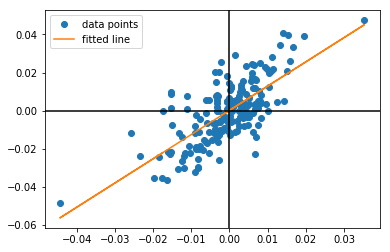

In [208]:
# Y축에 삼성전자 수익률, X축에 시장 수익률을 놓고 Linear Regression한다. 
slope, intercept, r_value, p_value, std_err = stats.linregress(samsung_KOSPI.KOSPI_rateofchange, samsung_KOSPI.samsung_rateofchange)

x = samsung_KOSPI.KOSPI_rateofchange
y = samsung_KOSPI.samsung_rateofchange

plt.plot(x, y, 'o', label='data points')
plt.plot(x, intercept + slope*x, label='fitted line')

plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.legend()
plt.show()

print

In [215]:
# slope가 우리가 찾는 Beta이다. 

print("""
Regression line: y = {intercept} + {slope} * x


- R-squared: {r_value}

- Standard Error: {std_err}

- P-value: {p_value}
""".format(intercept=intercept, slope=slope, r_value=r_value**2, std_err=std_err, p_value=p_value))


Regression line: y = 0.0001689371490473571 + 1.2707183529827124 * x


- R-squared: 0.5159477403832252

- Standard Error: 0.09073684188656382

- P-value: 8.328397467585863e-31



In [219]:
# Calculate CAPM

print("""
무위험 수익률 Rf = {Rf}

시장 수익률 Rm = {Rm}

삼성전자의 Beta = {slope}

이니까 


CAPM을 계산하면

R_samsung = Rf + B * (Rm - Rf) 
          = {Rf} + {slope} * {Rm_Rf}
          = {R_samsung}

""".format(Rf=Rf, Rm=Rm, slope=slope, Rm_Rf=Rm-Rf, R_samsung={Rf+slope*(Rm-Rf)}))


무위험 수익률 Rf = 1.85603392877489

시장 수익률 Rm = 2.087299384974095

삼성전자의 Beta = 1.2707183529827124

이니까 


CAPM을 계산하면

R_samsung = Rf + B * (Rm - Rf) 
          = 1.85603392877489 + 1.2707183529827124 * 0.23126545619920513
          = {2.1499071883781395}


